# Hydrological balance

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
#from mpl_toolkits.basemap import Basemap

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## NetCFD with month data

### Specify the file location

In [3]:
data = './temp-precip/era5-month-iceland.nc'
ds = nc.Dataset(data)

### Metadata

In [4]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-03-28 16:55:09 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/0aa2d2fd-096a-4108-a183-5c2c8361a713-adaptor.mars.internal-1680022509.0985382-1044-14-tmp.nc /cache/tmp/0aa2d2fd-096a-4108-a183-5c2c8361a713-adaptor.mars.internal-1680022449.285466-1044-12-tmp.grib
    dimensions(sizes): longitude(131), latitude(51), time(48)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 sf(time, latitude, longitude), int16 smlt(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


In [9]:
print(ds.__dict__)

{'Conventions': 'CF-1.6', 'history': '2023-03-28 14:34:08 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/0d64cac8-8f78-4bbe-990b-6d6a2a71b8e1-adaptor.mars.internal-1680014047.6071782-6062-9-tmp.nc /cache/tmp/0d64cac8-8f78-4bbe-990b-6d6a2a71b8e1-adaptor.mars.internal-1680013999.6829462-6062-7-tmp.grib'}


### Extracting the data

In [6]:
LON = list(ds['longitude'][:])
LAT = list(ds['latitude'][:])

prcp = np.array(ds['tp'][:]) #mean per day
temp = np.array(ds['t2m'][:]) #mean per day
smlt = np.array(ds['smlt'][:]) #m of water equivalent
sf = np.array(ds['sf'][:])

### Converting the time

In [7]:
time = np.array(ds['time'][:])
origin = datetime.datetime(1900,1,1)
datime = []
for h in time :
    datime.append(origin + datetime.timedelta(hours = float(h)))


## Geographic data : watershed

In [8]:
surfdata = pd.read_csv("D:/MEMOIRE/SIG/djupa/watershed_v289_intersect.csv")

In [9]:
surfdata

,fid,DN,fid_2,cat,value,label,x_cent,y_cent,surface
0,300,-32293,2,1,1,NaN,-16.747,64.978,2.626344e+08
1,336,-32201,2,1,1,NaN,-17.203,64.884,1.097672e+07
2,337,-32166,2,1,1,NaN,-16.928,64.907,3.592468e+07
3,338,-32166,2,1,1,NaN,-16.506,64.963,2.224630e+08
4,339,-32027,2,1,1,NaN,-16.288,64.985,9.985695e+07
5,369,-31128,2,1,1,NaN,-17.437,64.659,4.799569e+07
6,370,-31013,2,1,1,NaN,-17.240,64.742,2.989885e+08
7,371,-30878,2,1,1,NaN,-17.000,64.750,3.315023e+08
8,372,-31005,2,1,1,NaN,-16.752,64.753,3.232245e+08
9,373,-31395,2,1,1,NaN,-16.553,64.810,1.089112e+08


In [10]:
totsurf = np.sum(surfdata.surface)
print('Watershed area %0.1f m²' %totsurf)

Watershed area 2165459786.5 m²


### Computing the precipitation, ETR and snow melt with a surface ratio

In [106]:
dicth = {}
fid = list(surfdata.fid)
for idp in range(len(fid)) :
    lat = surfdata.y_cent[idp]
    lon = surfdata.x_cent[idp]
    idxLat = find_nearest(LAT, lat)
    idxLong = find_nearest(LON, lon)
    dsurf = surfdata.surface[idp]/totsurf
    #print(dsurf)
    P = []
    T = []
    SM = []
    SF = []
    for t in range(len(time)) :
        if t != len(time)-1 :
            dt = datime[t+1]-datime[t]
            dt = dt.days
        else :
            dt = 31
        P.append(float(prcp[t][idxLat][idxLong])*dsurf*dt*1000)
        T.append(float(temp[t][idxLat][idxLong])-273.15)
        SM.append(float(smlt[t][idxLat][idxLong])*dsurf*dt*1000)
        SF.append(float(sf[t][idxLat][idxLong])*dsurf*dt*1000)
    
    LP = np.array(P)-np.array(SF)
    L = 0.05*np.array(T)**3 + 25*np.array(T) + 300
    W = LP #+ np.array(SM)
    ETR = np.array(W)/(0.9+np.array(W)**2/L**2)**1/2
    print(len(P),len(T),len(SM),len(ETR),len(SF))
    R = np.block([T,P,list(ETR),SF,SM])
    dicth.update({str(fid[idp]):R})
    #print(nantest)

48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48


### Sum the precipitation & Co.

In [107]:
tP = []
tETR = []
tLP = []
tSM = []
for a in dicth :
    tP.append(dicth[a][1])
    tETR.append(dicth[a][2])
    tLP.append(dicth[a][3])
    tSM.append(dicth[a][4])
sumP = np.sum(np.array(tP), axis = 0)
sumLP = np.sum(np.array(tP), axis = 0)
sumETR = np.sum(np.array(tETR), axis = 0)
sumSM = np.sum(np.array(tSM), axis = 0)

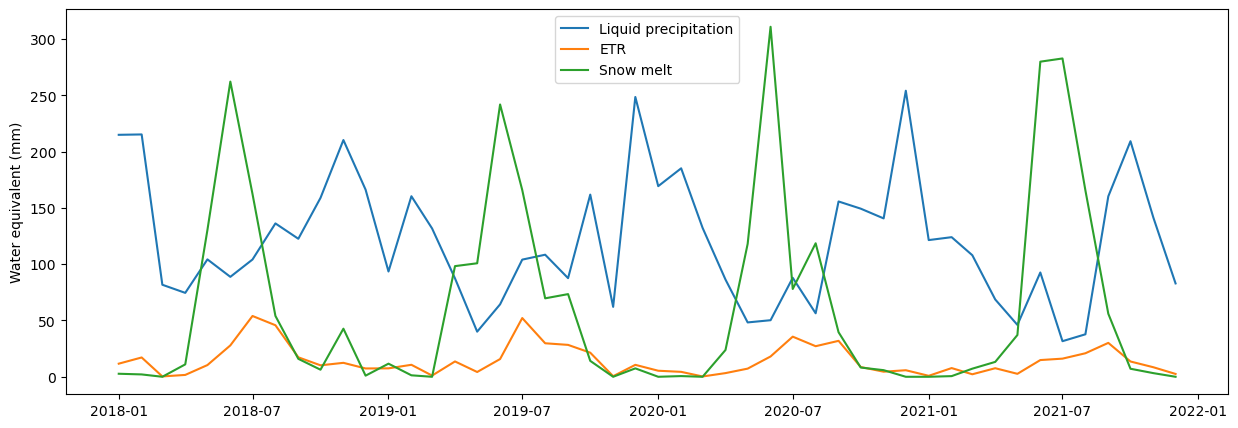

In [108]:
plt.figure(figsize=(15,5))
plt.plot(datime,sumLP, label='Liquid precipitation')
plt.plot(datime,sumETR, label='ETR')
plt.plot(datime,sumSM, label='Snow melt')
plt.ylabel('Water equivalent (mm)')
plt.legend()

## Analysis the water discharge

In [109]:
dhydro = pd.read_csv('D:/MEMOIRE/HYDRO/ALL-DVV/vdv_2018-2022-20230322092719-able-panda.csv',delimiter =';',low_memory=False) 

In [110]:
dich = {}

for a in dhydro :
    if a != 'Time' :
        pQ = np.array(dhydro[a])
        nantest = np.array(pd.notna(pQ))
        Q = np.extract(nantest,pQ).astype(str)
        Q = np.char.replace(Q,',','.').astype(object)
        T = np.extract(nantest,dhydro['Time']).astype(object)
        R = np.block([[T], [Q]])
        dich.update({a: R})
    #print(nantest)

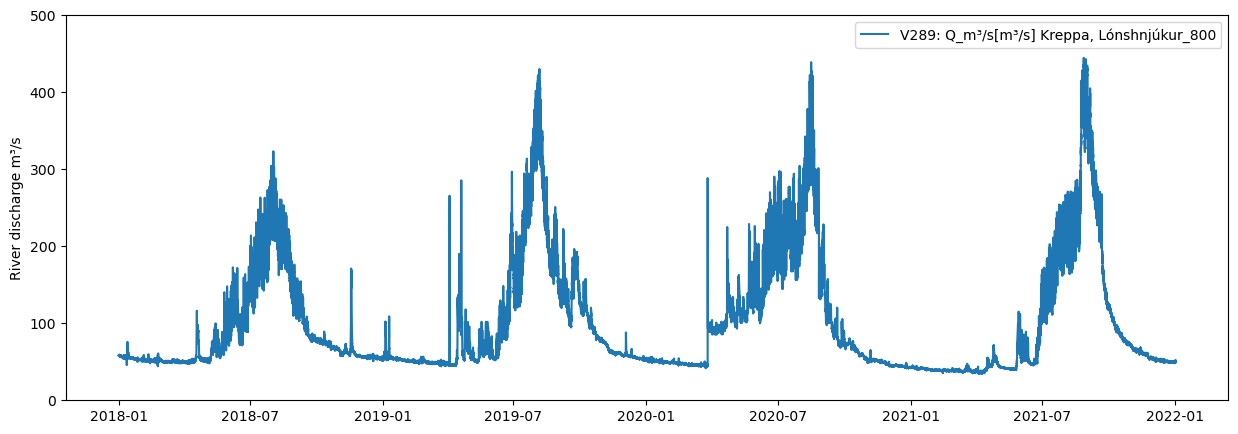

In [122]:
plt.figure(figsize=(15,5))
line = 1
for a in dich :
    if len(dich[a][0]) > 10 and line == 3:
        plt.plot(dich[a][0].astype(np.datetime64),dich[a][1].astype('float64'), label=a)
        plt.ylim(0,500)
    line += 1
plt.ylabel('River discharge m³/s')
plt.legend()
plt.show()

### Sum the discharge on the watershed area

In [112]:
disT = dich['V289: Q_m³/s[m³/s] Kreppa, Lónshnjúkur_800'][0]
disQ = dich['V289: Q_m³/s[m³/s] Kreppa, Lónshnjúkur_800'][1]

In [113]:
sQ = 0
t0 = datetime.datetime.strptime(disT[0], '%Y-%m-%d %H:%M:%S')
sumQ = []
for it in enumerate(disT) :
    tn = datetime.datetime.strptime(disT[it[0]], '%Y-%m-%d %H:%M:%S')
    if it[0] < len(disT) - 1 :
        t1 = datetime.datetime.strptime(disT[it[0]+1], '%Y-%m-%d %H:%M:%S') 
        dt = t1 - tn
    sQ += float(disQ[it[0]])*dt.seconds
    if tn.day == 1 and tn.hour == 0 and tn.minute == 0 and it[0]!=0 :
        #print(tn)
        sumQ.append(sQ)
        sQ = 0

In [114]:
sumQmm = np.array(sumQ)*1000/totsurf

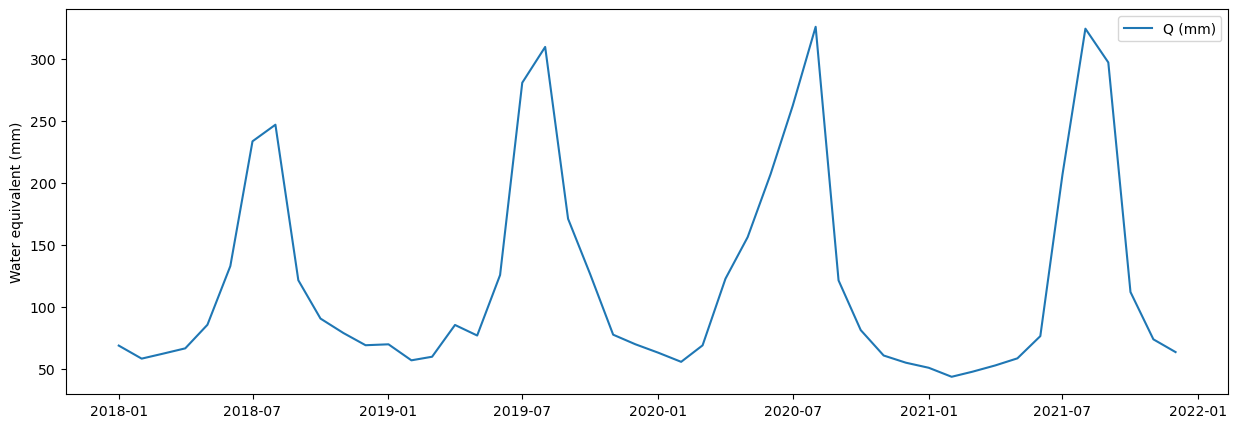

In [121]:
plt.figure(figsize=(15,5))
plt.plot(datime,sumQmm, label='Q (mm)')
#plt.plot(datime,sumETR, label='ETR')
#plt.plot(datime,sumSM, label='ETR')
plt.ylabel('Water equivalent (mm)')
plt.legend()

### Water balance
### P + SM = Q + ETR + dR => dR = P + SM - Q - ETR

In [116]:
dR = sumLP+sumSM-sumQmm-ETR

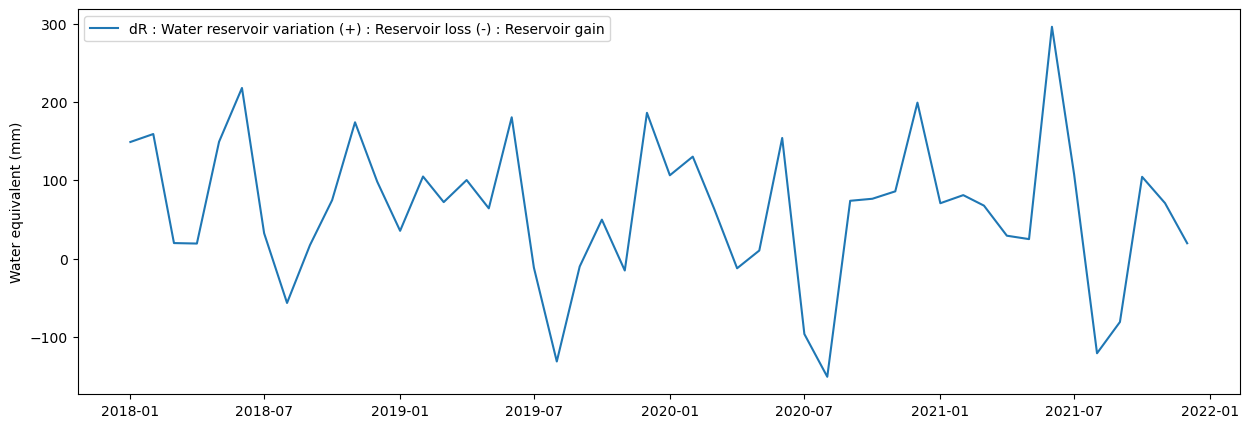

In [120]:
plt.figure(figsize=(15,5))
plt.plot(datime,dR, label='dR : Water reservoir variation (+) : Reservoir loss (-) : Reservoir gain')
plt.ylabel('Water equivalent (mm)')
plt.legend()

In [118]:
vR = []
R = 0
for elem in dR :
    R+=elem
    vR.append(R)

## Comparing dv/v and dR